In [1]:
# venv
import torch
import datetime as dt
print(torch.__version__)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

2.0.1+cu117
GPU is available.


In [1]:
from dotenv import load_dotenv
import os, subprocess, sys, time
from pyannote.core import Segment, Annotation
from pyannote.core.notebook import Notebook
import matplotlib.pyplot as plt
load_dotenv()
import pickle, json
import torch
from pyannote.audio import Pipeline
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.0",
                                               use_auth_token=os.getenv('HUGGINGFACE_TOKEN'))
os.environ["CUDA_VISIBLE_DEVICES"]="1"
pretrained_pipeline.to(torch.device("cuda"))

2024-01-25 13:12:20.695686238 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-01-25 13:12:20.695717516 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [34]:
# pretrained_pipeline.instantiate({
#     "segmentation": {
#         "min_duration_off": 0.0,
#     },
#     "clustering": {
#         "method": "centroid",
#         "min_cluster_size": 12,
#         "threshold": 0.6,
#     },
# })

# pretrained_pipeline.parameters(instantiated=True)

{'segmentation': {'min_duration_off': 0.0},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 12,
  'threshold': 0.6}}

In [2]:
def create_annotation_plot(speaker_timelines, start_time, end_time, filename=None):
    custom_diarization = Annotation()
    
    for speaker_key in speaker_timelines.keys():
        for timeline in speaker_timelines[speaker_key]:
            if timeline[0] >= start_time and timeline[1] <= end_time:
                custom_diarization[Segment(timeline[0], timeline[1])] = speaker_key
            elif timeline[0] < start_time and timeline[1] <= end_time and timeline[1] >= start_time:
                custom_diarization[Segment(start_time, timeline[1])] = speaker_key
            elif timeline[0] >= start_time and timeline[0] <= end_time and timeline[1] > start_time:
                custom_diarization[Segment(timeline[0], end_time)] = speaker_key

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot the custom diarization result
    nb = Notebook()
    nb.plot_annotation(custom_diarization, ax, legend=True)

    # Customize the plot (if needed)
    ax.set_xlabel('Time')
    ax.set_yticks([])  # To hide the y-axis

    # Save the figure
#     fig.savefig(f'{filename}.png', bbox_inches='tight')
    fig.show()

In [3]:
audio_dir = "../../Videos/"

files = [
    f
    for f in os.listdir(audio_dir)
    if os.path.isfile(os.path.join(audio_dir, f))
    and os.path.splitext(os.path.join(audio_dir, f))[1] in [".mp4", ".wav"]
]
files

['StarTalk_Consciousness.mp4',
 'Video1.mp4',
 'StarTalk_Cosmic.mp4',
 'StarTalk_Mars.mp4',
 'Video3.mp4',
 'StarTalk_Cosmic.wav',
 'StarTalk_Farming.mp4',
 'PL_1_0_250.mp4',
 'Video2.mp4',
 'StarTalk_Farming.wav',
 'StarTalk_Consciousness.wav',
 'Video4.mp4']

In [4]:
def get_audio_from_video(video_dir, video_name):
    
    audioFilePath = os.path.join(video_dir, f"{os.path.splitext(video_name)[0]}.wav")
    command = "ffmpeg -y -i %s -qscale:a 0 -ac 1 -vn -threads %d -ar 16000 %s -loglevel panic" % (
        os.path.join(video_dir, video_name),
        10,
        audioFilePath,
    )
    subprocess.call(command, shell=True, stdout=None)
    sys.stderr.write(
        time.strftime("%Y-%m-%d %H:%M:%S") + " Extract the audio and save in %s \r\n" % (audioFilePath)
    )
    
    return audioFilePath

In [11]:
audio_path = get_audio_from_video(audio_dir, 'StarTalk_Cosmic.mp4')
audio_path

2024-01-25 12:52:11 Extract the audio and save in ../../Videos/StarTalk_Cosmic.wav 


'../../Videos/StarTalk_Cosmic.wav'

In [5]:
audio_path = '../../Videos/StarTalk_Cosmic.wav'

In [6]:
diarization = pretrained_pipeline(audio_path)
audio_output = {}
for duration,_, speaker_key in diarization.itertracks(yield_label=True):
    if speaker_key in audio_output.keys():
        audio_output[speaker_key].append((duration.start,duration.end))
    else:
        audio_output[speaker_key] = [(duration.start,duration.end)]

In [9]:
audio_output

{'SPEAKER_00': [(0.008488964346349746, 29.261460101867577),
  (29.80475382003396, 30.415959252971142),
  (31.112054329371816, 34.10016977928693),
  (34.49066213921901, 35.797962648556876),
  (36.23938879456706, 41.6723259762309),
  (42.945670628183365, 44.30390492359932),
  (49.227504244482176, 56.90152801358234),
  (56.91850594227504, 57.207130730050935),
  (57.903225806451616, 61.34974533106961),
  (61.655348047538205, 64.7453310696095),
  (64.8132427843803, 64.9490662139219),
  (65.0, 65.66213921901527),
  (75.81494057724959, 77.61460101867573),
  (82.50424448217316, 84.10016977928692),
  (85.76400679117148, 99.39728353140916),
  (101.87606112054328, 111.723259762309),
  (112.09677419354838, 112.1137521222411),
  (112.13073005093378, 113.82852292020374),
  (122.94567062818336, 123.69269949066214),
  (123.86247877758913, 124.59252971137522),
  (125.0848896434635, 125.15280135823429),
  (125.33955857385399, 134.23599320882855),
  (134.54159592529712, 137.76740237691004),
  (166.409168

In [ ]:
window_num = 2
window_size = 300
create_annotation_plot(audio_output, window_num*window_size, (window_num+1) * window_size)

In [6]:
final_output = {}
for f in files:
    print(f)
    diarization = pretrained_pipeline(os.path.join(audio_path, f))
    audio_output = {}
    for duration,_, speaker_key in diarization.itertracks(yield_label=True):
        if speaker_key in audio_output.keys():
            audio_output[speaker_key].append((duration.start,duration.end))
        else:
            audio_output[speaker_key] = [(duration.start,duration.end)]
    final_output[f] = audio_output

StarTalk_FlyingVehicles_2670_2710.mp3
StarTalk_Sleep_2379_2443.mp3
StarTalk_Sleep_748_796.mp3
StarTalk_FlyingVehicles_674_719.mp3
StarTalk_FlyingVehicles_1980_2040.mp3
StarTalk_FlyingVehicles_1001_1043.mp3
StarTalk_Sleep_1152_1211.mp3
StarTalk_FlyingVehicles_300_340.mp3
NDT_India_19_88.mp3
StarTalk_FlyingVehicles_2446_2508.mp3
MagnusCarlson_542_599.mp3
StarTalk_CMBR_92_152.mp3
StarTalk_FlyingVehicles_949_1000.mp3
StarTalk_Sleep_2470_2551.mp3
StarTalk_Sleep_2099_2160.mp3
StarTalk_Sleep_1980_2041.mp3
StarTalk_Sleep_1602_1639.mp3
StarTalk_Sleep_382_450.mp3
StarTalk_FlyingVehicles_780_811.mp3
StarTalk_CMBR_190_225.mp3
StarTalk_CMBR_270_308.mp3
StarTalk_CMBR_319_356.mp3


In [27]:
def find_overlap(intervals1, intervals2):
    overlap = 0
    total_duration1 = 0
    total_duration2 = 0
    # Calculate the total duration of intervals in intervals1
    for start, end in intervals1:
        total_duration1 += end - start

    # Calculate the total duration of intervals in intervals2 and find the overlap
    for start, end in intervals2:
        total_duration2 += end - start
        for s1, e1 in intervals1:
            common_start = max(s1, start)
            common_end = min(e1, end)
            if common_start < common_end:
                overlap += common_end - common_start

    # Calculate the percentage of overlap with respect to intervals1
    percentage_overlap1 = (overlap / total_duration1) * 100

    # Calculate the percentage of overlap with respect to intervals2
    percentage_overlap2 = (overlap / total_duration2) * 100

    return percentage_overlap1, percentage_overlap2

In [42]:
# Set the video duration and window size
video_duration = 2700
window_size = 200
min_contribution_percentage = 5

# Initialize a list to store valid intervals
valid_intervals = []

# Iterate over the video with a rolling window
for start_time in range(0, video_duration - window_size + 1):
    end_time = start_time + window_size

    # Check if each speaker contributes at least 10% in the window
    valid_window = True
    for speaker, timeline_list in audio_output.items():
        overlap1, overlap2 = find_overlap(intervals1=[(start_time, end_time)], intervals2=timeline_list)
        if overlap2 < min_contribution_percentage:
            valid_window = False
            break
    # If the window is valid, add it to the list
    if valid_window:
        valid_intervals.append((start_time, end_time))

# Print the valid intervals
for interval in valid_intervals:
    print(f"Valid interval: {interval}")

Valid interval: (170, 370)
Valid interval: (171, 371)
Valid interval: (172, 372)
Valid interval: (173, 373)
Valid interval: (174, 374)
Valid interval: (175, 375)
Valid interval: (176, 376)
Valid interval: (177, 377)
Valid interval: (178, 378)
Valid interval: (179, 379)
Valid interval: (180, 380)
Valid interval: (181, 381)
Valid interval: (182, 382)
Valid interval: (183, 383)
Valid interval: (184, 384)
Valid interval: (185, 385)
Valid interval: (186, 386)
Valid interval: (187, 387)
Valid interval: (188, 388)
Valid interval: (189, 389)
Valid interval: (190, 390)
Valid interval: (191, 391)
Valid interval: (192, 392)
Valid interval: (193, 393)
Valid interval: (194, 394)
Valid interval: (339, 539)
Valid interval: (1130, 1330)
Valid interval: (1131, 1331)
Valid interval: (1132, 1332)
Valid interval: (1133, 1333)
Valid interval: (1134, 1334)
Valid interval: (1135, 1335)
Valid interval: (1136, 1336)
Valid interval: (1137, 1337)
Valid interval: (1138, 1338)
Valid interval: (1139, 1339)
Valid in

In [11]:
with open("Audios/diarize.pkl", "wb") as file:
    pickle.dump(final_output, file)

In [5]:
f = 'PM_Progun.mp3'
diarization = pretrained_pipeline(f)
audio_output = {}
for duration,_, speaker_key in diarization.itertracks(yield_label=True):
    if speaker_key in audio_output.keys():
        audio_output[speaker_key].append((duration.start,duration.end))
    else:
        audio_output[speaker_key] = [(duration.start,duration.end)]
create_annotation_plot(audio_output, os.path.splitext(f)[0])

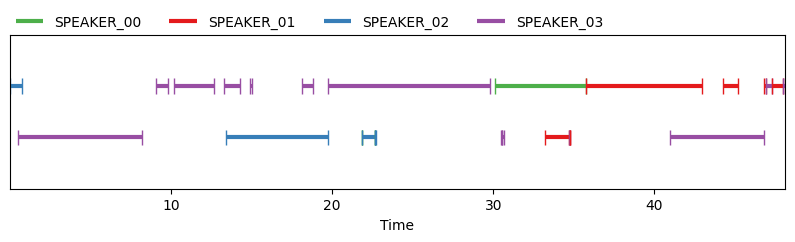

In [35]:
f = '../../output/StarTalk_Sleep_748_796/pyavi/audio.wav'
diarization = pretrained_pipeline(f)
audio_output = {}
for duration,_, speaker_key in diarization.itertracks(yield_label=True):
    if speaker_key in audio_output.keys():
        audio_output[speaker_key].append((duration.start,duration.end))
    else:
        audio_output[speaker_key] = [(duration.start,duration.end)]
create_annotation_plot(audio_output, os.path.splitext(f)[0])